In [3]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import uuid

In [4]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_29202/1375469573.py:9: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [5]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

def state_init_bell_pairs_explicitCNOT(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    qc.Add_Gate(Quantum_Gate("AZ",0,angle=(-1/20)))
        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            pass
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
    if (clifford=="XX"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("FTXA",2*i,2*i+1,angle=1/4))
            
def bell_measurement(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
        
def bell_measurement_explicitCNOT(qc,n):
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

def add_XX_clifford(circ,index):
    circ.z(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.z(2*index)
    circ.cx(2*index,2*index+1)
    circ.s(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.h(2*index+1)
    circ.s(2*index+1)
    circ.h(2*index+1)
        
    
    

In [6]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [28]:
#define error model parameters

import math
from math import pi
from qiskit.quantum_info import Statevector
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

#basic t2 error model
# T1 and T2 values for qubit
T1 = 1000000000000
T2 = 1000000000000

# Error probabilities
# prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.03   # 2-qubit gate
 
# Depolarizing quantum errors
# error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = depolarizing_error(prob_2, 2)


In [29]:
# Set_Mapping([1,3,4,5,2])
nqubit=2
# ancillae=2
S=Quantum_Circuit(2*nqubit,"qc")
# S_explicit=Quantum_Circuit(2*nqubit,"qc_e")
total_depth=5
depth=[2**x for x in range(1,total_depth+1)] #depth for Concatenation
C=20#number of samples per depth

all_circuits=[]#a list of lists. circuits for all depths. each element is a list of circuit of a certain depth d.
all_circuits_explicit=[]
circuits=[] #a list of circuits with a certain depth d
circuits_explicit=[]
eab_data=[] #a list of dictionaries. Each dictionary is the results and relevant info of one circuit
results={}

clifford_layer="CNOT"
#for qiskit 
backend = AerSimulator()
# t_echo=0

for d in depth:
    print ("\nDepth = %d"%d)
    print ("Number of samples = %d"%C)
    time_delay= (300+80)*d*1000 #in ns
    noise_model = NoiseModel()
    errors_delay = [thermal_relaxation_error(T1, T2, time_delay)]*nqubit
    for j in range (nqubit):
        noise_model.add_quantum_error(errors_delay[j], "delay",[nqubit+j])
    for j in range (nqubit):
        noise_model.add_quantum_error(error_2, "cx",[j,j+nqubit])
    for i in range (C):
# #gates circuitt
#         S.depth=0
#         S.gates=[]
# #gates explicit cnot circuit    
#         S_explicit.depth=0
#         S_explicit.gates=[]

#qiskit_circ=QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_state = QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_gates = QuantumCircuit(nqubit)

        # #gates circuit state prep
        # state_init_bell_pairs(S,nqubit)
        # #gates explicit CNOT circuit state prep
        # state_init_bell_pairs_explicitCNOT(S_explicit,nqubit)
        #qiskit circuit state prep
        for j in range(nqubit):
            prepare_bell_state_1q(qiskit_c_state,j,j+nqubit)
        qiskit_c_state.barrier()

        
        for j in range(d):
            #gates circuit add pauli layer
            layer=add_pauli_twirl(S,nqubit)
            # #gates explicit cnot circuit add pauli layer
            # layer=add_pauli_twirl(S_explicit,nqubit)
            
            #qiskit circuit add pauli layer
            for q in range(nqubit):
                pauli_gate_1q(qiskit_c_gates,q,pauli=layer[q])


            # #gates circuit add clifford layer
            # add_clifford_layer(S,nqubit,clifford_layer)
            # #gates explicit cnot circuit add clifford layer
            # add_clifford_layer(S_explicit,nqubit,clifford_layer)
          
            #qiskit circuit add clifford layer
            if clifford_layer == 'Id':
                pass
            elif clifford_layer == 'CNOT':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    qiskit_c_gates.cx(2*q,2*q+1)
            elif clifford_layer == 'XX':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    add_XX_clifford(qiskit_c_gates,q)
            qiskit_c_gates.barrier()
            
        #gates circuit add Pauli twirl
        layer=add_pauli_twirl(S,nqubit)
        # #gates explicit cnot circuit add Pauli twirl
        # layer=add_pauli_twirl(S_explicit,nqubit)
        #qiskit circuit add Pauli twirl
        for j in range(nqubit):
            pauli_gate_1q(qiskit_c_gates,j,pauli=layer[j])
            #save the stablizer representation
        cliffordOp = Clifford(qiskit_c_gates)

        
        #for qiskit: append gates to state
        qiskit_circ = qiskit_c_state.compose(qiskit_c_gates,range(nqubit))

        # add dephasing noise to ancilla qubits
        for j in range (nqubit,2*nqubit):
            qiskit_circ.delay(time_delay,unit="ns",qarg=j)
        
        # #gates circuti bell measurement
        # bell_measurement(S,nqubit)
        # #gates explicit cnot circuti bell measurement
        # bell_measurement_explicitCNOT(S_explicit,nqubit)
        
        #qiskit circuti bell measurement
        for j in range(nqubit):
            bell_measurement_1q(qiskit_circ,j,j+nqubit)
        qiskit_circ.barrier(range(2*nqubit))
        qiskit_circ.measure(range(2*nqubit),range(2*nqubit))
        
        # qiskit_circ.draw('mpl')

#         #for qiskit 
        qc_compiled = transpile(qiskit_circ, backend)
        job_sim = backend.run(qc_compiled, shots=2000,noise_model=noise_model)
        result_sim = job_sim.result()
        counts_qiskit = result_sim.get_counts(qc_compiled)


#         # circuits.append(S.GatesLab_Sequence())
#         # circuits_explicit.append(S_explicit.GatesLab_Sequence())

# #stuff not needed
# #         print (S.GatesLab_Sequence())
# #         print (S_explicit.GatesLab_Sequence())
# #         statef=S.Simulate()
# #         statef=S_explicit.Simulate()
# #         statef.population=[round (x) for x in statef.population]
# #         statef_explicit.population=[round (x) for x in statef_explicit.population]
# #         print (statef.population)
# #         print (statef_explicit.population)  
                   
#         #package and format results
        results["n"]=nqubit
        results["L"]=d
        results["clifford"] = cliffordOp.to_dict()
        results["clifford_layer"] = clifford_layer
# #         statef=S.Simulate()
#         statef=S_explicit.Simulate()
#         counts=[round(2000*x) for x in statef.population]
        
#         counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        results["counts"]=counts_qiskit
        eab_data.append(results)
# #         if 0==0:
# #             print (results)
# #             print(counts_qiskit)
# #             print (cliffordOp)
        results={}
        
#     all_circuits.append(circuits)
#     all_circuits_explicit.append(circuits_explicit)
#     for line in circuits_explicit:
#         print (line)
#     circuits=[]
#     circuits_explicit=[]

# filename = str(uuid.uuid4())
# filename+="XX13452noS_explicitCNOT_FT_0516"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/"+filename, "wb") as fp:
#     pickle.dump(eab_data, fp)



Depth = 2
Number of samples = 20

Depth = 4
Number of samples = 20

Depth = 8
Number of samples = 20

Depth = 16
Number of samples = 20

Depth = 32
Number of samples = 20


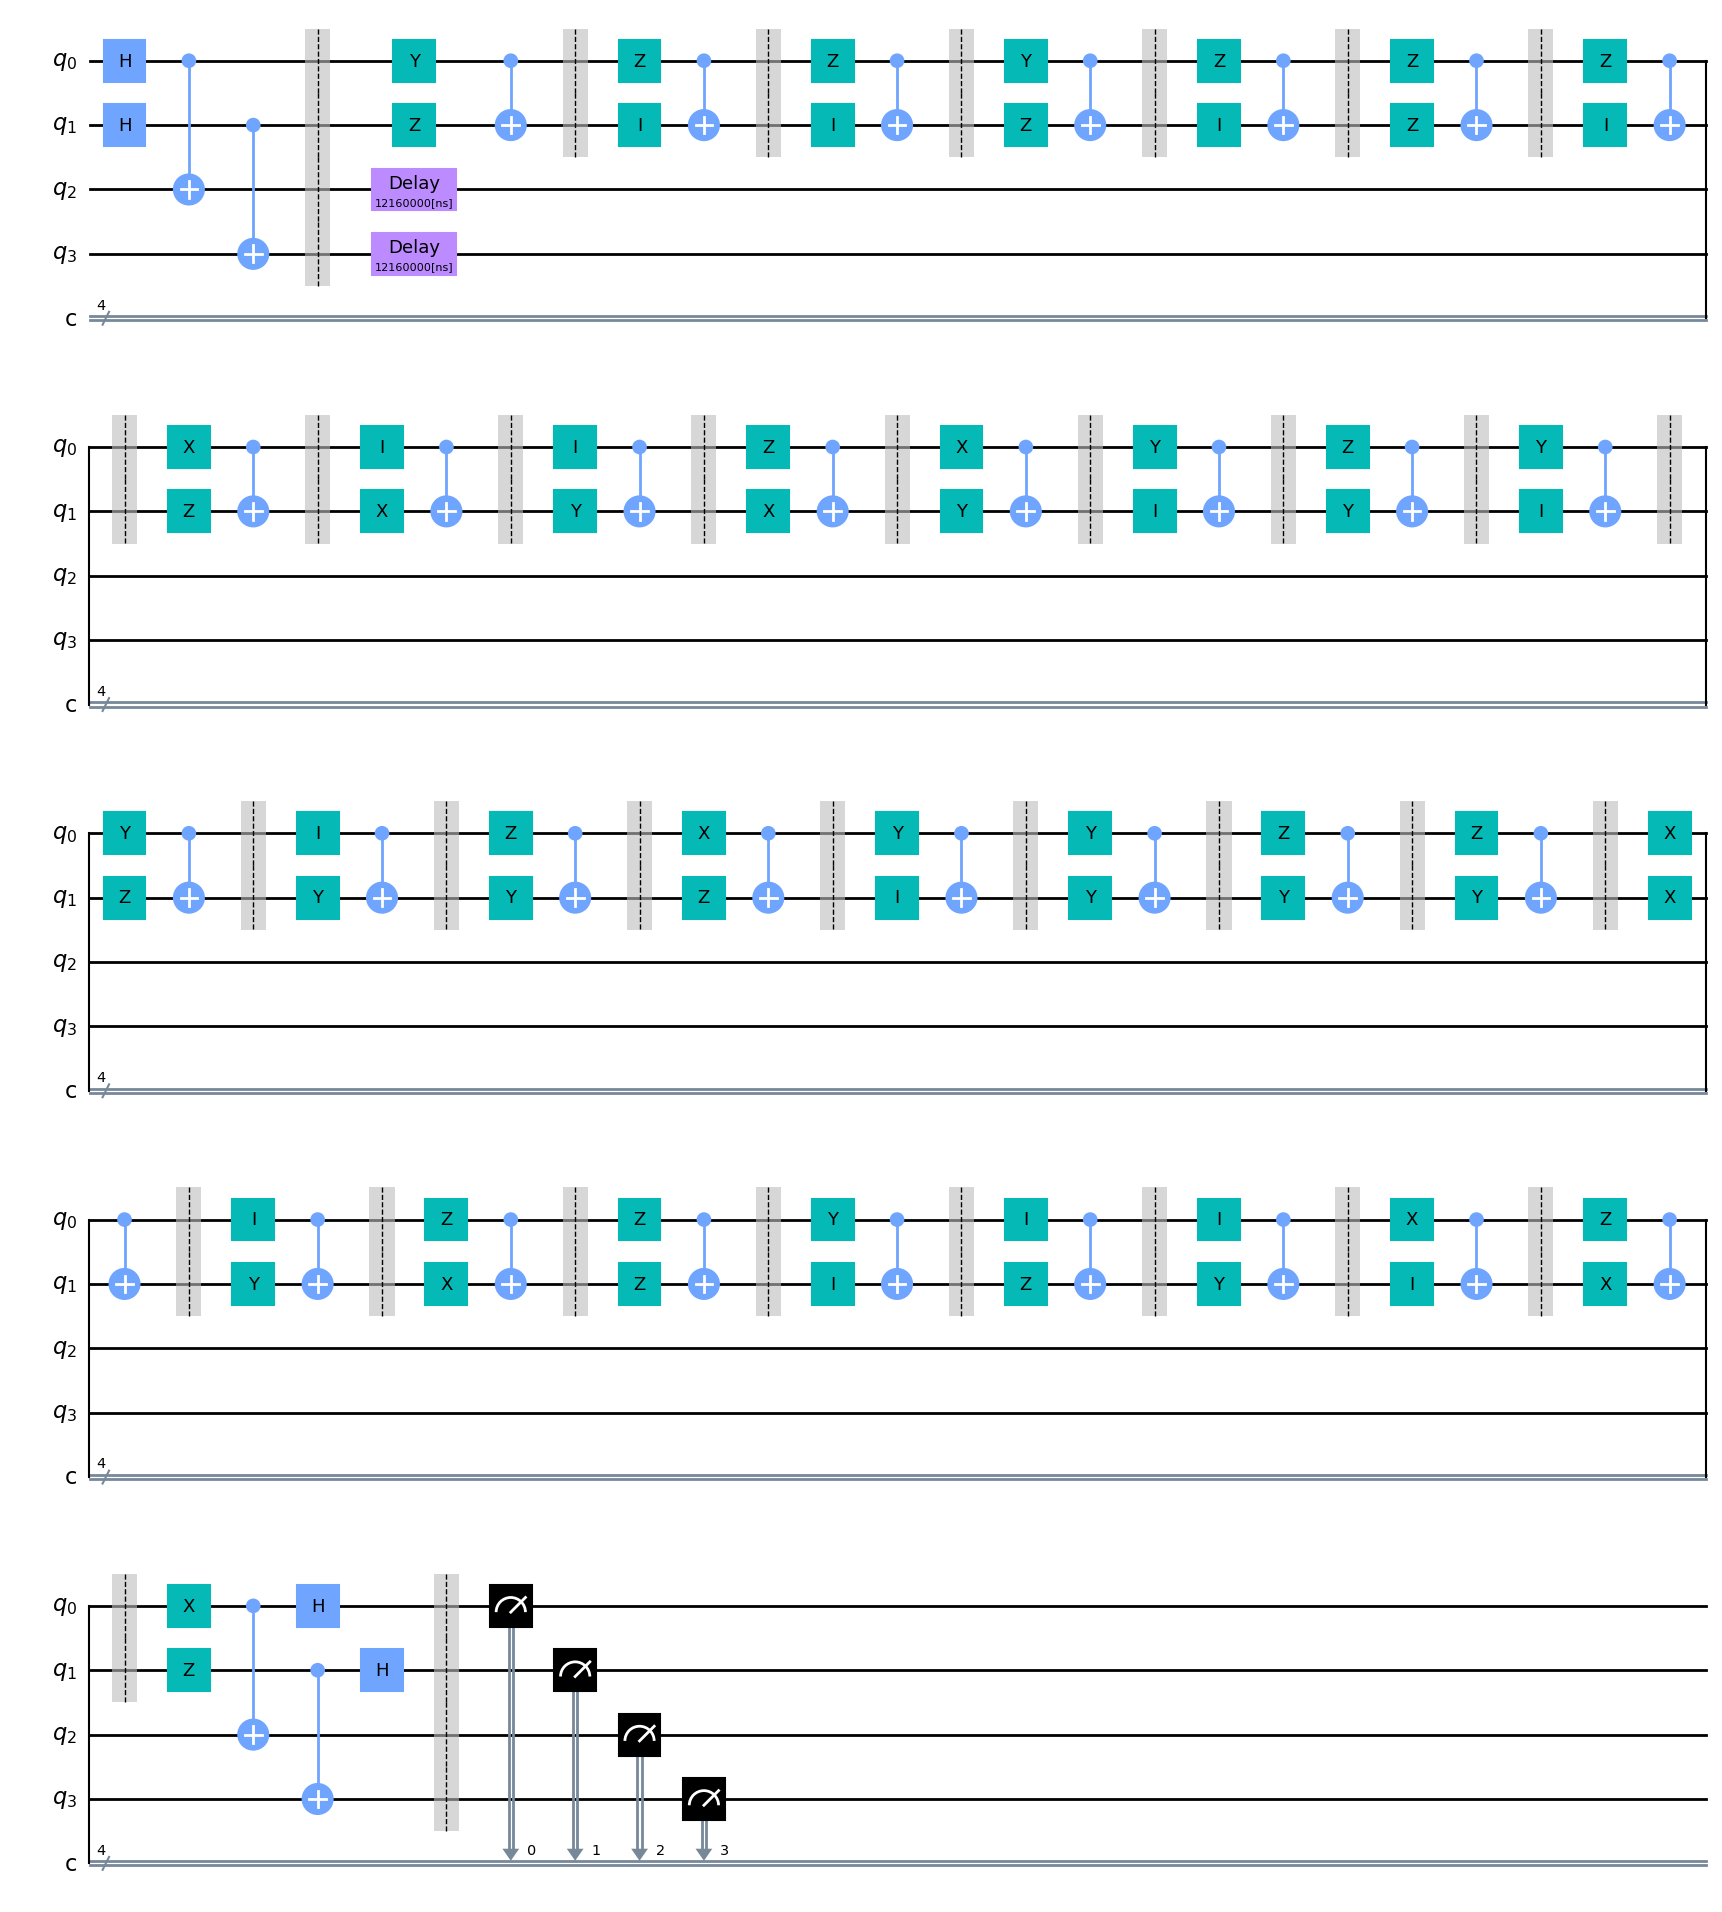

In [30]:
qiskit_circ.draw('mpl')

In [31]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_data, pauli_request_list)

print (eab_result)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.943, 0.935, 0.938, 0.941, 0.941, 0.954, 0.952, 0.948, 0.955, 0.943, 0.949, 0.938, 0.949, 0.948, 0.94, 0.937, 0.926, 0.946, 0.941, 0.944], 4: [0.951, 0.945, 0.937, 0.944, 0.948, 0.944, 0.92, 0.95, 0.936, 0.942, 0.933, 0.933, 0.951, 0.937, 0.933, 0.941, 0.938, 0.937, 0.947, 0.952], 8: [0.94, 0.937, 0.932, 0.937, 0.945, 0.945, 0.947, 0.928, 0.947, 0.952, 0.953, 0.924, 0.942, 0.937, 0.939, 0.942, 0.936, 0.941, 0.948, 0.95], 16: [0.94

In [32]:
raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  6.639051824364195e-05
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 7.252093313092622e-05 6.675604253142753e-05
YI 1.0998490220903712e-05 6.628955815177698e-05
ZI 9.46077153521907e-05 8.361520526928835e-05
IX 6.366049978345778e-05 7.242023187175617e-05
XX 0.0001470585318849027 9.610454340411165e-05
YX 8.00680753773042e-05 9.041637885819386e-05
ZX 0.00011949953834822225 9.684943724924475e-05
IY -6.373023960115631e-06 7.685613397734548e-05
XY 9.095924079749462e-05 0.00010187202967326343
YY 3.273620432764357e-05 9.022928512057998e-05
ZY 6.420265285433935e-05 9.911127466650621e-05
IZ 1.532821476157853e-05 7.571171816344273e-05
XZ 0.0001101823064444396 0.00010056341888514289
YZ 6.542286240673878e-05 0.00010671646780488006
ZZ 0.00010137605016746765 0.00010564436473653021


In [38]:
np.save("IdwithT2error_sim_EAB_T2_50ms",[1-fidelity_list[pauli_label] for pauli_label in pauli_request_list])

In [13]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 0.998889011266246
XI -6.938893903907228e-18
YI 0.0
ZI 0.0005420867571843541
IX -1.284966970396817e-07
XX 6.938893903907228e-18
YX 0.0
ZX 9.684162455281253e-08
IY 3.060598716131402e-08
XY 6.938893903907228e-18
YY 0.0
ZY 1.0490852075939472e-09
IZ 0.0005611214179923954
XZ -6.938893903907228e-18
YZ 0.0
ZZ 7.780558577141772e-06


In [9]:
# True value for this specific noise model
# eps=0
# def f_true(P):
#     ans = 0.0
#     for Pi in P:
#         if Pi == 'Z' or Pi == 'Y':
#             ans += 2*eps
#     return ans
# def p_true(P):
#     if P == "XI" or P == "IX":
#         return eps
#     else:
#         return 0.0

# print("Label / True infidelity/ True Pauli error")
# for P in pauli_request_list:
#     print(P[::-1]," ",f_true(P)," ",p_true(P))

Label / True infidelity/ True Pauli error
II   0.0   0.0
XI   0.0   0
YI   0.0   0.0
ZI   0.0   0.0
IX   0.0   0
XX   0.0   0.0
YX   0.0   0.0
ZX   0.0   0.0
IY   0.0   0.0
XY   0.0   0.0
YY   0.0   0.0
ZY   0.0   0.0
IZ   0.0   0.0
XZ   0.0   0.0
YZ   0.0   0.0
ZZ   0.0   0.0


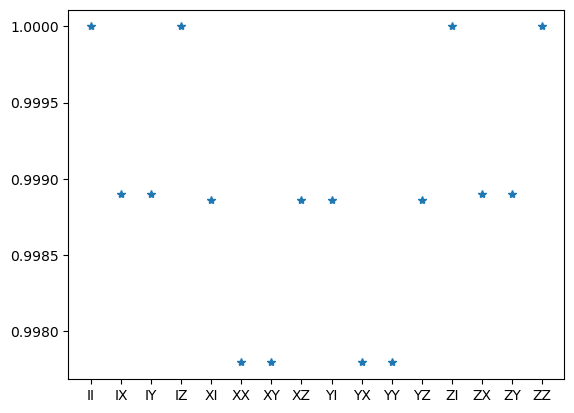

In [14]:
plt.plot([pauli_label for pauli_label in pauli_request_list],[fidelity_list[pauli_label] for pauli_label in pauli_request_list],"*")